In [1]:
import numpy as np
from sklearn.datasets import fetch_openml


X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = X.values
y = y.astype(int).values
X = ((X / 255.) - .5) * 2

In [2]:
from sklearn.model_selection import train_test_split


X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=10000, random_state=123, stratify=y)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_temp, y_temp, test_size=5000, random_state=123, stratify=y_temp)

del X_temp, y_temp, X, y

In [3]:
def sigma(z):
    return 1. / (1 + np.exp(-z))

def int_to_onehot(y, num_labels):
    ary = np.zeros((y.shape[0], num_labels))
    for i, val in enumerate(y):
        ary[i, val] = 1

    return ary

class NeuralNetMLP:
    def __init__(self, n_features, n_hidden, n_classes, random_seed=123, learning_rate=0.1):
        self.learning_rate = learning_rate
        self.rng = np.random.RandomState(random_seed)
        self.n_features = n_features
        self.n_cl = n_classes
        self.n_hidden = n_hidden
        self.weights_h = self.rng.normal(loc=0.0, scale =0.1, size=(self.n_hidden, self.n_features))
        self.bias_h = np.zeros(self.n_hidden)
        self.weights_out = self.rng.normal(loc = 0.0, scale=0.1, size=(self.n_cl, self.n_hidden))
        self.bias_out = np.zeros(self.n_cl)

    def forward(self, x):
        z_h = np.dot(x, self.weights_h.T) + self.bias_h
        a_h = sigma(z_h)
        z_out = np.dot(a_h, self.weights_out.T) + self.bias_out
        a_out = sigma(z_out)
        return a_h, a_out

    def backward(self, x, a_h, a_out, y):
        y = int_to_onehot(y, self.n_cl)
        #out
        d_L_d_a_out = -2. * (y - a_out)/y.shape[0]
        d_a_out_d_z_out = a_out * (1. - a_out)
        d_l_d_z_out = d_L_d_a_out * d_a_out_d_z_out
        d_L_d_w_out = np.dot((d_l_d_z_out).T, a_h)
        d_L_d_b_out = np.sum(d_l_d_z_out, axis=0)

        #hidden
        d_z_out_d_a_h = self.weights_out
        d_a_h_d_z_h = a_h * (1. - a_h)
        d_l_d_a_h = np.dot((d_l_d_z_out), d_z_out_d_a_h)
        d_L_d_w_h = np.dot((d_l_d_a_h * d_a_h_d_z_h).T, x)
        d_L_d_b_h = np.sum(d_l_d_a_h * d_a_h_d_z_h, axis=0)
        return (d_L_d_w_out, d_L_d_b_out, d_L_d_w_h, d_L_d_b_h)

    def partial_fit(self, x, y):
        a_h, a_out = self.forward(x)
        d_L_d_w_out, d_L_d_b_out, d_L_d_w_h, d_L_d_b_h = self.backward(x, a_h, a_out, y)
        self.weights_h -= self.learning_rate * d_L_d_w_h
        self.bias_h -= self.learning_rate * d_L_d_b_h
        self.weights_out -= self.learning_rate * d_L_d_w_out
        self.bias_out -= self.learning_rate * d_L_d_b_out
        return self

    def _mini_batch_generator(self, X, Y, size_batch):

        idx = np.arange(X.shape[0])
        np.random.shuffle(idx)

        for i in range(0, idx.shape[0] - size_batch + 1, size_batch):
            idxi = idx[i:i + size_batch]
            yield X[idxi], Y[idxi]



    def minibatch_fit(self, X, Y, n_epoch, size_batch = 32):
        for _ in range(n_epoch):
            minibatch_gen = self._mini_batch_generator(X, Y, size_batch)
            for x, y in minibatch_gen:
                self.partial_fit(x, y)

        return self

In [4]:
model = NeuralNetMLP(n_features=28*28,
                     n_hidden=50,
                     n_classes=10)

In [5]:
def mse_loss(targets, infl, num_labels=10):
    onehot_targets = int_to_onehot(targets, num_labels=num_labels)
    return np.mean((onehot_targets - infl)**2)

def accuracy(targets, predicted_labels):
    return np.mean(predicted_labels == targets)

_, infl = model.forward(X_valid)
mse = mse_loss(y_valid, infl)

predicted_labels = np.argmax(infl, axis=1)
acc = accuracy(y_valid, predicted_labels)

In [6]:
print(f'Initial validation MSE: {mse:.1f}')
print(f'Initial validation accuracy: {acc*100:.1f}%')

Initial validation MSE: 0.3
Initial validation accuracy: 9.4%


In [7]:
model.minibatch_fit(X_train, y_train, n_epoch=50, size_batch=32)

In [8]:
_, infl = model.forward(X_valid)
mse = mse_loss(y_valid, infl)

predicted_labels = np.argmax(infl, axis=1)
acc = accuracy(y_valid, predicted_labels)

In [9]:
print(f'Initial validation MSE: {mse:.1f}')
print(f'Initial validation accuracy: {acc*100:.1f}%')

Initial validation MSE: 0.0
Initial validation accuracy: 96.1%


In [10]:
_, infl = model.forward(X_test)
mse = mse_loss(y_test, infl)

predicted_labels = np.argmax(infl, axis=1)
acc = accuracy(y_test, predicted_labels)
print(f'Initial test MSE: {mse:.1f}')
print(f'Initial test accuracy: {acc*100:.1f}%')

Initial test MSE: 0.0
Initial test accuracy: 95.8%


In [11]:
misclassified_images = X_test[y_test != predicted_labels][:25]
misclassified_labels = predicted_labels[y_test != predicted_labels][:25]
correct_labels1 = y_test[y_test != predicted_labels][:25]

In [12]:
classified_images = X_test[y_test == predicted_labels][:25]
classified_labels =  predicted_labels[y_test != predicted_labels][:25]
correct_labels2 =  predicted_labels[y_test != predicted_labels][:25]

In [13]:
import matplotlib.pyplot as plt

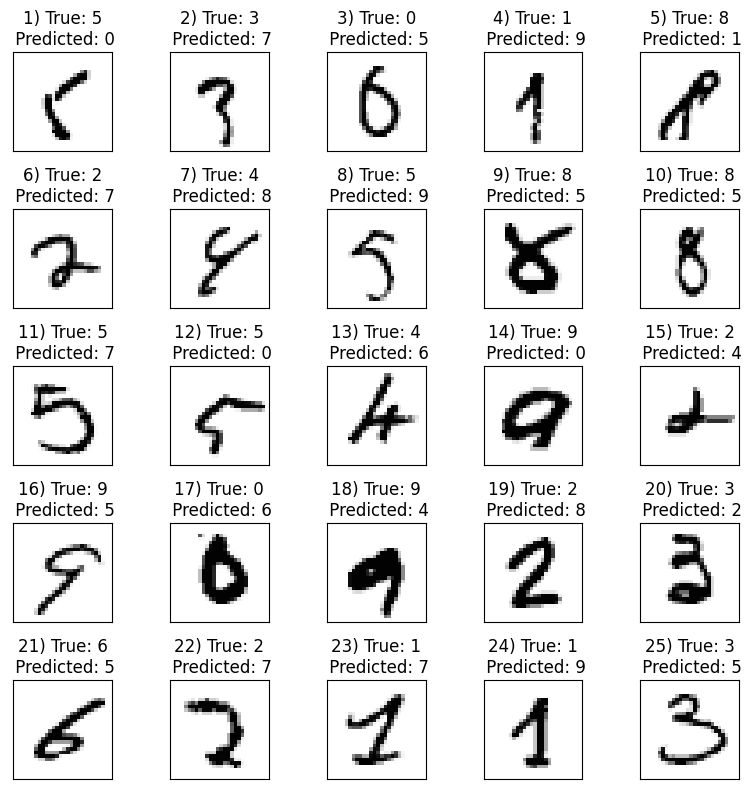

In [14]:
fig, ax = plt.subplots(nrows=5, ncols=5,
                       sharex=True, sharey=True, figsize=(8, 8))
ax = ax.flatten()
for i in range(25):
    img = misclassified_images[i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title(f'{i+1}) '
                    f'True: {correct_labels1[i]}\n'
                    f' Predicted: {misclassified_labels[i]}')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
#plt.savefig('figures/11_09.png', dpi=300)
plt.show()

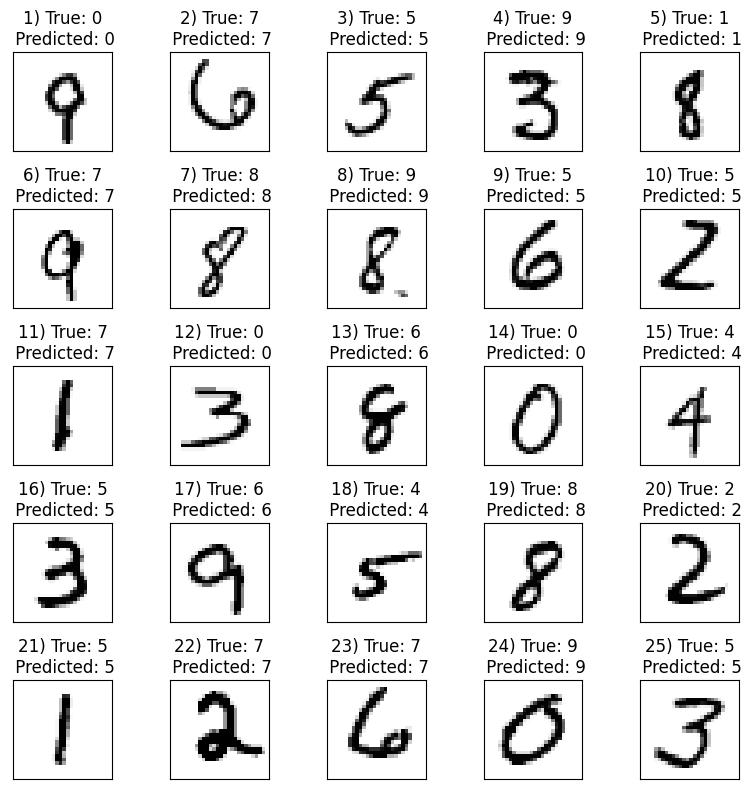

In [15]:
fig, ax = plt.subplots(nrows=5, ncols=5,
                       sharex=True, sharey=True, figsize=(8, 8))
ax = ax.flatten()
for i in range(25):
    img = classified_images[i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title(f'{i+1}) '
                    f'True: {correct_labels2[i]}\n'
                    f' Predicted: {classified_labels[i]}')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
#plt.savefig('figures/11_09.png', dpi=300)
plt.show()

In [16]:
import numpy as np
import torch
import torch.nn as nn
import pandas as pd

from IPython.display import Image
import torchvision
from torchvision import transforms
from torch.nn.functional import one_hot

from torch.utils.data import DataLoader, TensorDataset


image_path = './'
transform = transforms.Compose([transforms.ToTensor()])

mnist_train_dataset = torchvision.datasets.MNIST(root=image_path,
                                           train=True,
                                           transform=transform,
                                           download=True)
mnist_test_dataset = torchvision.datasets.MNIST(root=image_path,
                                           train=False,
                                           transform=transform,
                                           download=False)

batch_size = 64
torch.manual_seed(1)

train_dl = DataLoader(mnist_train_dataset, batch_size, shuffle=True)

100%|██████████| 9.91M/9.91M [00:01<00:00, 7.20MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 281kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 2.79MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.07MB/s]


In [17]:
hidden_units = [50, 25]
image_size = mnist_train_dataset[0][0].shape
input_size = image_size[0] * image_size[1] * image_size[2]

all_layers = [nn.Flatten()]
for hidden_unit in hidden_units:
    layer = nn.Linear(input_size, hidden_unit)
    all_layers.append(layer)
    all_layers.append(nn.ReLU())
    input_size = hidden_unit

all_layers.append(nn.Linear(hidden_units[-1], 10))
all_layers.append(torch.nn.Softmax(1))
model = nn.Sequential(*all_layers)

model

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=50, bias=True)
  (2): ReLU()
  (3): Linear(in_features=50, out_features=25, bias=True)
  (4): ReLU()
  (5): Linear(in_features=25, out_features=10, bias=True)
  (6): Softmax(dim=1)
)

In [18]:
class torch_NeuralNetMLP(nn.Module):
    def __init__(self, hidden_units):
        super().__init__()
        self.hidden_units = hidden_units
        image_size = mnist_train_dataset[0][0].shape
        input_size = image_size[0] * image_size[1] * image_size[2]

        all_layers = [nn.Flatten()]
        for hidden_unit in self.hidden_units:
            layer = nn.Linear(input_size, hidden_unit)
            all_layers.append(layer)
            all_layers.append(nn.ReLU())
            input_size = hidden_unit

        all_layers.append(nn.Linear(hidden_units[-1], 10))
        all_layers.append(torch.nn.Softmax(1))
        self.model = nn.Sequential(*all_layers)

    def forward(self, x):
        return self.model(x)


hidden_units = [50, 25]

torch_model = torch_NeuralNetMLP(hidden_units=hidden_units)

In [19]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [20]:
torch.manual_seed(1)
num_epochs = 50
accuracy_hist_train_ = []
for epoch in range(num_epochs):
    accuracy_hist_train = 0

    for x_batch, y_batch in train_dl:
        pred = model(x_batch)
        loss = loss_fn(pred, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
        accuracy_hist_train += is_correct.sum()
    accuracy_hist_train /= len(train_dl.dataset)
    accuracy_hist_train_.append(accuracy_hist_train)
    print(f'Epoch {epoch}  Accuracy {accuracy_hist_train:.4f}')

Epoch 0  Accuracy 0.8183
Epoch 1  Accuracy 0.9229
Epoch 2  Accuracy 0.9353
Epoch 3  Accuracy 0.9442
Epoch 4  Accuracy 0.9502
Epoch 5  Accuracy 0.9556
Epoch 6  Accuracy 0.9585
Epoch 7  Accuracy 0.9625
Epoch 8  Accuracy 0.9654
Epoch 9  Accuracy 0.9688
Epoch 10  Accuracy 0.9704
Epoch 11  Accuracy 0.9720
Epoch 12  Accuracy 0.9740
Epoch 13  Accuracy 0.9750
Epoch 14  Accuracy 0.9761
Epoch 15  Accuracy 0.9772
Epoch 16  Accuracy 0.9780
Epoch 17  Accuracy 0.9788
Epoch 18  Accuracy 0.9799
Epoch 19  Accuracy 0.9811
Epoch 20  Accuracy 0.9813
Epoch 21  Accuracy 0.9819
Epoch 22  Accuracy 0.9822
Epoch 23  Accuracy 0.9826
Epoch 24  Accuracy 0.9834
Epoch 25  Accuracy 0.9834
Epoch 26  Accuracy 0.9840
Epoch 27  Accuracy 0.9839
Epoch 28  Accuracy 0.9848
Epoch 29  Accuracy 0.9847
Epoch 30  Accuracy 0.9852
Epoch 31  Accuracy 0.9856
Epoch 32  Accuracy 0.9862
Epoch 33  Accuracy 0.9857
Epoch 34  Accuracy 0.9863
Epoch 35  Accuracy 0.9865
Epoch 36  Accuracy 0.9867
Epoch 37  Accuracy 0.9868
Epoch 38  Accuracy 0.9

In [21]:
import plotly
import plotly.graph_objs as go
import plotly.express as px
layout = go.Layout(
    width=1000,
    height=500,
    title="Accuracy_train",
    xaxis=dict(title='Epoch'), font=dict(size=20),
    yaxis=dict(title='Accuracy')
)

fig = go.Figure(layout=layout)
fig.add_trace(go.Scatter(x=np.arange(0, 50), y=accuracy_hist_train_))
fig.update_yaxes(automargin=True)
fig.update_xaxes(automargin=True)
fig.show()

In [22]:
pred = model(mnist_test_dataset.data / 255.)
is_correct = (torch.argmax(pred, dim=1) == mnist_test_dataset.targets).float()
print(f'Test accuracy: {is_correct.mean():.4f}')


Test accuracy: 0.9709
